In [1]:
import os
from pathlib import Path

import json

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans, DBSCAN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model

from machine_learning.encoders import WaveNet_Encoder, CNN_Encoder, CNN_LSTM_Encoder, CNN_LSTM_SA_Encoder, LSTM_Encoder, WaveNetOpt_Encoder
from machine_learning.decoders import CNN_Decoder, WaveNet_Decoder, CNN_LSTM_Decoder, LSTM_Decoder
from machine_learning.anomaly_detection import AutoEncoder, ED_Feedback

In [2]:
# Versuchsparameter
normal = 0
anomalies_percentage = 2
dataset = 'energy'
model_type = 'cnn-class'

# ML-Parameter
batch_size = 32

# automatisch generiert
classes = [0,1,2,3] #list(range(num_anomaly+1))
percentage = anomalies_percentage/100
model_str = f'{dataset}-c{"".join(str(c)+"-" for c in classes)}p{anomalies_percentage}.hdf5'

model_dict = {
    'cnn': (CNN_Encoder, CNN_Decoder),
    'cnn-opt': (CNN_Encoder, CNN_Decoder),
    'cnn-mec': (CNN_Encoder, CNN_Decoder),
    'cnn-class': (CNN_Encoder, CNN_Decoder),
    'wavenet': (WaveNet_Encoder, WaveNet_Decoder),
    'lstm': (LSTM_Encoder, LSTM_Decoder),
    'cnn-lstm': (CNN_LSTM_Encoder, CNN_LSTM_Decoder),
    'cnn-lstm-sa': (CNN_LSTM_SA_Encoder, CNN_LSTM_Decoder),
}

# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
dataset_path = os.path.join(data_path, dataset)
trainingset_path = os.path.join(dataset_path, "train")
testset_path = os.path.join(dataset_path, "test")

models_path = os.path.join(working_dir, "saved_models")
output_path = os.path.join(models_path, model_type)
Path(output_path).mkdir(parents=True, exist_ok=True)

print(model_str)
print(trainingset_path)
print(output_path)

energy-c0-1-2-3-p2.hdf5
/Users/david/repos/deep-anomaly-detection/data/energy/train
/Users/david/repos/deep-anomaly-detection/saved_models/cnn-class


In [3]:
def aursad(dataset='train', classes=classes):

    path = None
    if dataset.lower() == 'train':
        path = trainingset_path
    elif dataset.lower() == 'test':
        path = testset_path
    else:
        raise ValueError("Invalid dataset specified")
    
    x = np.load(os.path.join(path, "x.npy"))
    y = np.load(os.path.join(path, "y.npy"))
    
    # extract the relevant classes only
    mask = [i in classes for i in y]
    x = x[mask,:,:]
    y = y[mask]
    
    return x, y

def unsupervised(percentage=percentage, batch_size=batch_size):
    
    x,y = aursad()
        
    num_normal_samples = np.sum(y == normal)
    num_anomalies = int(num_normal_samples / (1-percentage) * percentage)

    # extracts the first anomalous occurencies, until the desired percentage is achieved
    anomaly_idx = y != normal
    cum_anomaly_idx = np.cumsum(anomaly_idx)
    anomaly_mask = cum_anomaly_idx <= num_anomalies

    mask = np.logical_or(y == normal, anomaly_mask)

    x = x[mask,::]
    y = y[mask]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[:n]
       
    return x, y

def semi_supervised(batch_size=batch_size):
    
    return unsupervised(percentage=0, batch_size=batch_size)

def supervised(dataset = "train", batch_size = batch_size):
    
    x,y = aursad(dataset=dataset)
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[:n]
       
    return x, y

def holdout_validation(x, y, percentage=0.8, batch_size=batch_size):

    split_idx = int((len(y) * percentage // batch_size) * batch_size)

    x_train = x[:split_idx,::]
    y_train = y[:split_idx]
    x_val = x[split_idx:,::]
    y_val = y[split_idx:]

    return (x_train, y_train), (x_val, y_val)


x_peek, _= aursad()
sequence_length = x_peek.shape[1]
num_features = x_peek.shape[2]

print(f'Sequence length = {sequence_length}')
print(f'Number of features = {num_features}')

print(len(unsupervised(percentage=percentage)[0]))

Sequence length = 480
Number of features = 4
1120


In [4]:
latent_dim = 6

# load the training data
train_x, _ = unsupervised()

# build the model
vaeAD = AutoEncoder(encoder=model_dict[model_type][0], decoder=model_dict[model_type][1],
                  input_shape=train_x.shape, latent_dim=latent_dim, is_variational=False)

vae = vaeAD.get_model()
vae.summary()

encoder = vaeAD.get_encoder()
encoder.summary()

decoder = vaeAD.get_decoder()
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 4)]          0         
_________________________________________________________________
cnn-encoder (Functional)     (None, 6)                 19934     
_________________________________________________________________
cnn-decoder (CNN_Decoder)    (None, 480, 4)            22684     
Total params: 42,618
Trainable params: 42,618
Non-trainable params: 0
_________________________________________________________________
Model: "cnn-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 474, 8)            232       
____________________________________

In [5]:
# train the VAE on MNIST digits
x, y = unsupervised()
(x_train, _), (x_val, _) = holdout_validation(x, y)
print(x_train.shape)

callbacks = [
        keras.callbacks.ModelCheckpoint(
        monitor = 'val_loss',
        filepath = os.path.join(output_path, model_str), 
        save_weights_only = False,
        save_best_only = True),

        keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
        ]

history = None
training = False

if training:
    history = vae.fit(x_train, x_train, epochs=360, shuffle=True, batch_size=batch_size,
        callbacks=callbacks, validation_data=(x_val, x_val))
    with open(os.path.join(output_path, "history.json"), 'w') as file:
            json.dump(history.history, file)
else:
    vae.load_weights(os.path.join(output_path, model_str))

(896, 480, 4)


In [6]:
def plot_history(history, metrics):

    for metric in metrics:
        data = history.history[metric]
        plt.plot(data)
    plt.legend(metrics)

unsupervised_metrics = ["loss", "val_loss"]
#plot_history(history, unsupervised_metrics)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-10 14:35:23.016012: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-10 14:35:23.016189: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


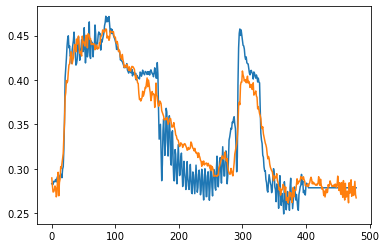

0.46577592063884937


In [7]:
f = 0
plt.plot(x_train[31,:,f])

pred_x = vae.predict(x_train[:64, :, :])

plt.plot(pred_x[31, :, f])

plt.show()

print(max(x_train[11,:,f]))

In [8]:
#keras.utils.plot_model(vae, show_shapes = True)

### Aktives Lernen - Feedback für das Gesamtmodell
Im unüberwachten Szenario ist der Verlust unverändert, im überwachten Szenario wird auf den Verlus der BinaryCrossEntropyLoss des Klassifikator aufaddiert

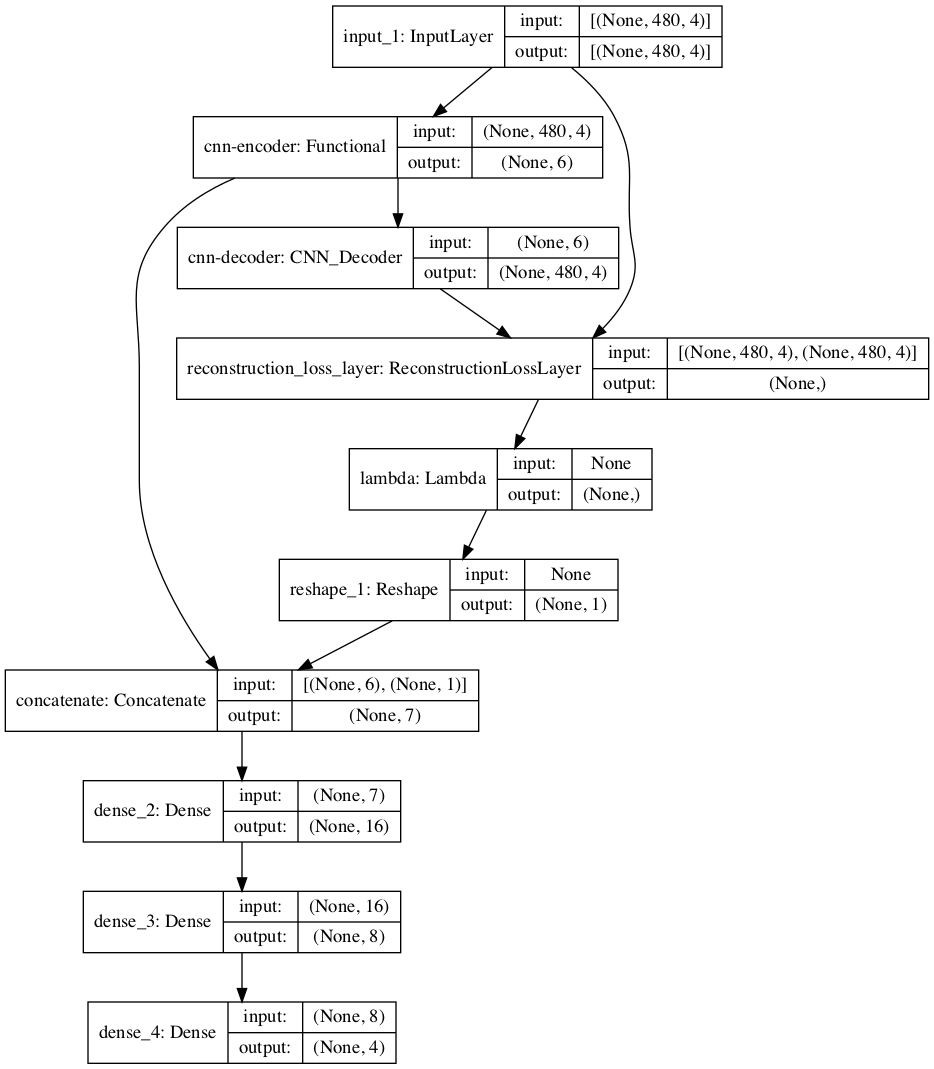

In [9]:
activeAD = ED_Feedback(vaeAD, num_classes=len(classes))
keras.utils.plot_model(activeAD.get_supervised(), show_shapes=True)

In [10]:
#keras.utils.plot_model(vae_al, show_shapes = True)

In [11]:
def attention_visualizer():
    
    #(orig, _), (_, _) = aursad()
    
    attention_vis = vaeAD.encoderWrapper.attention_model()
    
    scores = attention_vis.predict(x_train[:batch_size,:,:])[0,:,:]
    #scores = np.log(scores)
    print("scores: ",scores.shape)
    print(f'max: {np.max(scores)}, min: {np.min(scores)}')

    #plt.imshow(scores, cmap='hot', interpolation='nearest')
    #plt.show()
    
    n = scores.shape[0]
    n = n//10
    
    print(np.sum(scores, axis=1))
    
    fig, (ax1, ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(10,6))
    im = ax1.imshow(scores)
    
    ax1.set_xticks(np.arange(10)*n)
    ax1.set_yticks(np.arange(10)*n)

    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax1.text(j*n, i*n, np.round(scores[i*n, j*n],2), ha="center", va="center", color="w")

    ax1.set_title("Attention heat map")
    
    ax2.plot(x_train[0,:,0],-np.arange(0,len(x_train[0,:,0])))
    ax2.set_ylim(-len(x_train[0,:,0]),0)
    
    fig.tight_layout()
    plt.show()
   
#attention_visualizer()

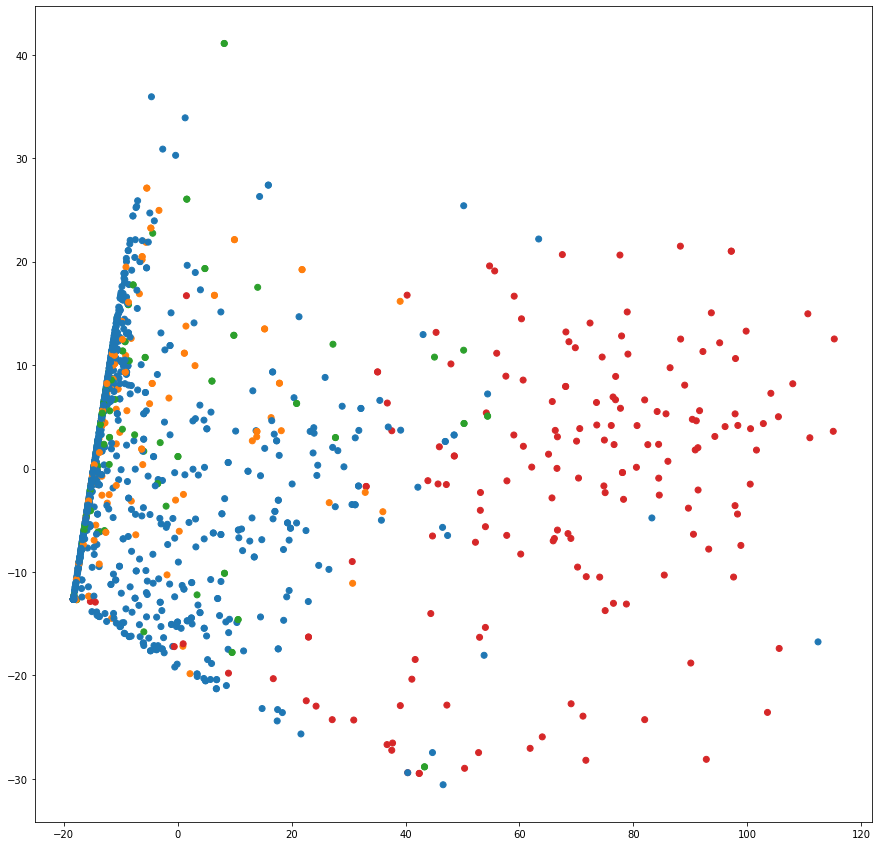

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def color_from_label(labels):
    l2c = {0:'tab:blue',
           1:'tab:orange',
           2:'tab:green',
           3:'tab:red',
           4:'tab:purple',
          }
    return [l2c[label] for label in labels]


def latent_space_pca(dim=2, dataset='train'):

    x, y = supervised(dataset=dataset)
    pca = PCA(n_components=dim)

    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    if dim==3:
        from mpl_toolkits import mplot3d
        fig = plt.figure(figsize=(8,8))
        ax = plt.axes(projection='3d')
        ax.scatter3D(z_pca[:,0], z_pca[:,1], z_pca[:,2], c=color_from_label(y), alpha=0.5)

    plt.figure(figsize=(15,15))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=color_from_label(y))

def visualize_latent_space(show_size=False, dataset='test'):

    x, y = supervised(dataset=dataset)

    z = encoder.predict(x)
    z_1 = z[:,0]
    z_2 = z[:,1]

    plt.figure(figsize=(15,15))
    plt.scatter(z_1, z_2, c=color_from_label(y))

#visualize_latent_space()
latent_space_pca(dim=2)

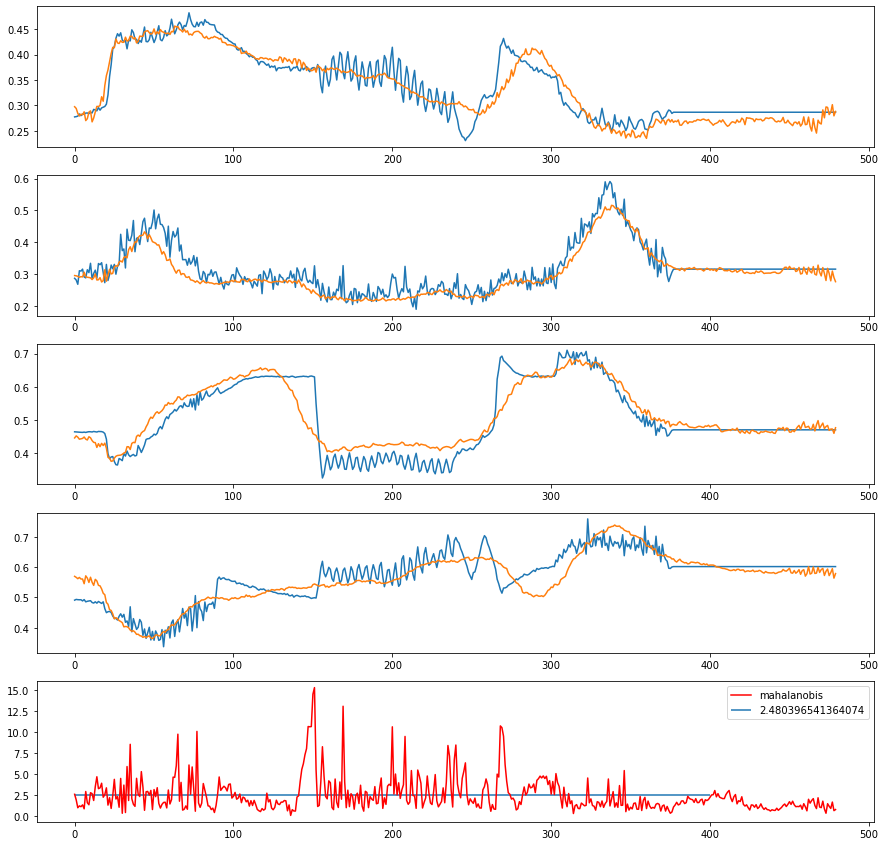

In [13]:
def mahalanobis_anomaly_score_series(x_true, x_pred):
    
    a = np.zeros((x_true.shape[0], x_true.shape[1]))
    for t in range(x_true.shape[1]):
        
        xt_true = x_true[:,t,:]
        xt_pred = x_pred[:,t,:]
        
        error = np.abs(xt_true-xt_pred)
    
        mu = np.mean(error, axis=0)
        #print(mu.shape)
        
        cov = np.cov(error, rowvar=False)
        if cov.shape == ():
            inv_cov = 1/cov
        else:
            inv_cov = np.linalg.inv(cov)
        #print(cov.shape)
        
        for s in range(x_true.shape[0]):
            e = error[s,:]

            if inv_cov.shape == ():
                a[s,t] = inv_cov * np.matmul((e-mu).T,(e-mu))
            else:
                a[s,t] = np.matmul(np.matmul((e-mu).T, inv_cov),(e-mu))
        
    return a

def show_anomaly_score(sample=0, label=0):
    
    orig, y = supervised()    
    x_pred = vae.predict(orig)

    a = mahalanobis_anomaly_score_series(orig, x_pred)
    
    s = 0
    while y[s] != label:
        s+=1   
            
    num_plots = orig.shape[2]+1
    fig, ax = plt.subplots(num_plots,1,figsize=(15,num_plots*3))
        
    for i, axi in enumerate(ax):
            
        if axi != ax[-1]:
            axi.plot(orig[s,:,i])
            axi.plot(x_pred[s,:,i])
        else:
            break
        
    ax[-1].plot(a[s,:], c="r")
    ax[-1].hlines(np.mean(a[s,:]), 0,400)
    ax[-1].legend(["mahalanobis", str(np.mean(a[s,:]))])
    plt.show()
        
show_anomaly_score(label=0)

In [14]:
#def load_vae(path):
#    mapping = {
#        "KLDivergenceLayer": KLDivergenceLayer,
#        "SampleLayer": SampleLayer,
#        "ReconstructionLossLayer": ReconstructionLossLayer,
#    }
#    vae = keras.models.load_model(path, custom_objects = mapping)
#    return vae

(1120, 480, 4)
22
15.7014214825965


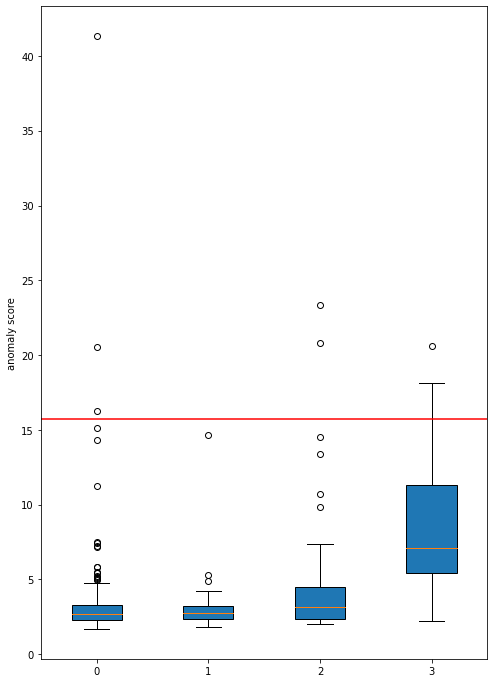

In [15]:
def mse(x_true, x_pred):
        
        loss = np.mean((x_true-x_pred)**2, axis=1)
        loss = np.mean(loss, axis=-1)
        return loss
    
def mae(x_true, x_pred):
    loss = np.mean(np.abs(x_true-x_pred), axis=1)
    loss = np.mean(loss, axis=-1)
    return loss

def mahalanobis_anomaly_score(x_true, x_pred):
    """Reduces the mahalanobis anomaly score series to a scalar"""
    series = mahalanobis_anomaly_score_series(x_true, x_pred)
    return np.mean(series, axis=1)

def anomaly_detection():
    
    x_test, y_test = supervised(dataset="test")
    x_pred = vae.predict(x_test)

    anomaly_scores = mahalanobis_anomaly_score(x_test, x_pred)

    all_scores = list()
    labels = [i for i in range(4)]

    for label in labels:
        scores = anomaly_scores[y_test== label]
        if len(scores) == 0:
            all_scores.append([0])
        else:
            all_scores.append(scores)
    
    fig, ax = plt.subplots(figsize=(8,12))
    ax.boxplot(all_scores,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=labels)
    ax.set_ylabel("anomaly score")
    
    x_train, y = unsupervised()
    print(x_train.shape)
    print(np.sum(y!=0))
    
    x_pred = vae.predict(x_train)
    anomaly_scores = mahalanobis_anomaly_score(x_train, x_pred)

    critical_anomaly_score = np.quantile(anomaly_scores, 0.98)
    print(critical_anomaly_score)
    
    ax.axhline(critical_anomaly_score, color="r")

#my_vae = load_vae(model_str)
anomaly_detection()

In [16]:
def quantile_threshold(p, loss_func=mae, return_loss=False):
    
    x, _ = supervised(dataset='train')
    x_hat = vae.predict(x)

    loss = loss_func(x, x_hat)
    threshold = np.quantile(loss, p)

    if return_loss:
        return threshold, loss
    else:
        return threshold

def confusion_matrix(actual, predicted, positive=0):
    """Computes the elements of a confusion matrix: tp, fp, fn, tn
    """

    tp = np.sum(np.logical_and(actual == positive, predicted == positive))
    tn = np.sum(np.logical_and(actual != positive, predicted != positive))
    fp = np.sum(np.logical_and(actual != positive, predicted == positive))
    fn = np.sum(np.logical_and(actual == positive, predicted != positive))
    
    return tp, fp, fn, tn

def accuracy(tp, fp, fn, tn):  
    return (tp+tn) / (tp+fp+fn+tn)

def precision(tp, fp, fn, tn):
    return tp/(tp+fp)

def recall(tp, fp, fn, tn):
    return tp/(tp+fn)

def f_score(tp, fp, fn, tn):
    p = precision(tp, fp, fn, tn)
    r = recall(tp, fp, fn, tn)
    return 2*p*r/(p+r)

def mcc_score(tp, fp, fn, tn):
    return (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

def baseline_ad(model = "unsupervised", loss_func=mae):
    
    ##x_train, _ = unsupervised(percentage=0.125)
    #x_train, _ = supervised(dataset="train")
    #    
    #x_pred = vae.predict(x_train)
    #training_loss = loss_func(x_train, x_pred)    
    #    
    #critical_anomaly_score = np.quantile(training_loss, 0.865)

    critical_anomaly_score = quantile_threshold(0.695, loss_func)
    
    print(f'Critical Anomaly Score = {critical_anomaly_score}')
    
    x_test, y_test = supervised(dataset="test")
    
    for i in range(5):
        count = np.sum(y_test==i)
        print(f'Anzahl {i}: {count}')
    
    x_test_pred = vae.predict(x_test)
    test_loss = loss_func(x_test, x_test_pred)    
    
    predicted = test_loss > critical_anomaly_score
    actual = y_test
    
    tp, fp, fn, tn = confusion_matrix(actual, predicted, positive=0)
    # spiegeln, da one-vs. all
    tp, fp, fn, tn = tn, fn, fp, tp
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    acc = accuracy(tp, fp, fn, tn)
    prec = precision(tp, fp, fn, tn)
    rec = recall(tp, fp, fn, tn)
    f1 = f_score(tp, fp, fn, tn)
    mcc = mcc_score(tp, fp, fn, tn)
    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')
    
    
baseline_ad(loss_func=mahalanobis_anomaly_score)

Critical Anomaly Score = 3.421462611320133
Anzahl 0: 267
Anzahl 1: 39
Anzahl 2: 40
Anzahl 3: 38
Anzahl 4: 0
TP = 60, TN = 209, FP = 58, FN = 57, N = 384
Accuracy = 0.7005208333333334, F1 = 0.5106382978723404, precision = 0.5084745762711864, recall = 0.5128205128205128, mcc = 0.2948896205888836


### Query Strategy

In [17]:
def naive_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)

    x = x[:budget,:,:]  
    y = y[:budget]   
    
    if return_idx:
        return (x,y), np.arange(budget)
    else:
        return x, y
    
def edgecase_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)

    threshold, score = quantile_threshold(0.695,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)
    #print(f'Threshold anomaly score: {threshold}')
        
    edge_cases = np.abs(score - threshold)    
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]
    
def most_anomalous_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    
    x_hat = vae.predict(x)
    score = mahalanobis_anomaly_score(x, x_hat)

    idx = np.argsort(score)
    idx = idx[-budget:]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]

def normal_query(budget, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    
    x_hat = vae.predict(x)
    score = mahalanobis_anomaly_score(x, x_hat)

    idx = np.argsort(score)
    idx = idx[:budget]
        
    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]


def clustering_query(budget, plot=False, return_idx=False):
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
      
    def dbscan_clustering(z, sample_weight=None):
        y = DBSCAN(min_samples=9, eps=0.1).fit_predict(z, sample_weight=sample_weight)
        return y
    
    def kmeans_clustering(z, sample_weight=None):
        kmeans = KMeans(n_clusters=10, random_state=0).fit(z, sample_weight=sample_weight)
        return kmeans.predict(z)
    

    threshold, score = quantile_threshold(0.695,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)

    sample_weight = score > threshold
    sample_weight = sample_weight * 3 + 1

    pca = PCA(n_components=2)
    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    y_cluster = dbscan_clustering(z_pca, sample_weight=sample_weight)
    
    import pandas as pd
    y_series = pd.Series(y_cluster)

    #print(y_series)
    grouped = y_series.groupby(y_series).count().reset_index()
    #print(grouped.columns)
    grouped=grouped.sort_values(0)
    #print(grouped)

    counts = grouped[0]
    #print(counts)

    idx = list()
    for j, (i, _) in enumerate(counts.iteritems()):
        
        remaining = budget - len(idx)
        samples_per_label = int(np.ceil(remaining/(len(counts)-j)))
        
        pos = np.arange(len(y_series))
        new_idx = pos[y_series==(i-1)][:samples_per_label]
        idx.extend(new_idx)
        #print(i,_,len(new_idx))

    if plot:
        print(np.unique(y_cluster))
        fig = plt.figure(figsize=(12,12))
        plt.scatter(z_pca[:,0], z_pca[:,1],c=y_cluster, s=100, cmap=cm.tab20)
        z_neg = z_pca[y_cluster<0,:]
        plt.scatter(z_neg[:,0], z_neg[:,1],c='k', s=100)
        plt.scatter(z_pca[idx,0], z_pca[idx,1], edgecolors='r', s=160, marker='o', facecolors='none')

    if return_idx:
        return (x[idx,::], y[idx]), idx
    else:
        return x[idx,::], y[idx]
    
#_,_ = clustering_query(128, plot=True)

## E2: Vergleich der Abfragestrategien

Für die Ergebnisse des CNN-LSTM Modell werden die verschiedenen Abfragestrategien verglichen

Darstellungen:
* a - Quantitativ: Wie viele Beispiele der einzelnen Klassen werden ausgewählt?
* b - Qualitativ: Welche Beispiele (Lage im latenten Raum) der einzelnen Klassen werden ausgewählt?
* c - Wirkung: Welche Leistungsfähigkeit des überwachten Modells ist damit erreichbar?

In [18]:
def e2a():
    budget = 256

    queries = [naive_query, edgecase_query, most_anomalous_query, normal_query, clustering_query]
    for query in queries:
        qx, qy = query(budget)

        num_i = [np.sum(qy==i) for i in range(4)]
        print(f"Query: {query.__name__}, Normal: {num_i[0]}, anomalies {np.sum(num_i[1:])}, class 1: {num_i[1]}, class 2: {num_i[2]}, class 3: {num_i[3]}")

e2a()

Query: naive_query, Normal: 187, anomalies 69, class 1: 26, class 2: 20, class 3: 23
Query: edgecase_query, Normal: 184, anomalies 72, class 1: 40, class 2: 29, class 3: 3
Query: most_anomalous_query, Normal: 69, anomalies 187, class 1: 16, class 2: 32, class 3: 139
Query: normal_query, Normal: 212, anomalies 44, class 1: 19, class 2: 25, class 3: 0
Query: clustering_query, Normal: 182, anomalies 74, class 1: 27, class 2: 22, class 3: 25


In [19]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
import pandas as pd

def e2b():
    # query the entire, non-restricted 
    x, y = unsupervised(percentage=0.99)
    y = y != 0
    
    pca = PCA(n_components=2)
    z = encoder.predict(x)
    z_pca = pca.fit_transform(z)

    x_hat = vae.predict(x)
    threshold, score = quantile_threshold(0.865,
                            loss_func=mahalanobis_anomaly_score, return_loss=True)
    
    # make the scores logarithmic for a enhanced depiction
    threshold, score = np.log(threshold), np.log(score)

    (_,_), idx = most_anomalous_query(budget=64, return_idx=True)

    fig= plt.figure(figsize=(12,8))
    grid_spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[8,1], width_ratios=[9.8, 0.2])

    ax1 = fig.add_subplot(grid_spec[0,0])
    ax2 = fig.add_subplot(grid_spec[1,:])
    axcb = fig.add_subplot(grid_spec[0,1])

    ax1.scatter(z_pca[:,0], z_pca[:,1], c=score, cmap=cm.RdYlGn_r)
    ax1.scatter(z_pca[idx,0], z_pca[idx,1], edgecolors='r', marker='o', facecolors='none', s=160)

    clb = fig.colorbar(cm.ScalarMappable(cmap=cm.RdYlGn_r, norm=Normalize(vmin=np.min(score), vmax=np.max(score))), cax=axcb)
    clb.set_label('log(Anomaliescore)', fontsize=14)
    ax2.scatter(score, np.ones(len(score)), s=20, c='k', label='Beispiel')
    ax2.set_yticks([])
    ax2.scatter(score[idx], np.ones(len(idx)), edgecolors='r', marker='o', facecolors='none', s=100, label='abgefragt')
    ax2.vlines(threshold, 0.95, 1.05, linestyle="--", color="tab:orange", label="Schwellenwert")
    ax2.set_xlabel("log(Anomaliescore)", fontsize=14)
    ax2.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5,-0.6), fontsize=14)
    plt.tight_layout()

    #df1 = pd.DataFrame({'score':np.log(score), 'queried':["Beispiele"]*len(score)})
    #df2 = pd.DataFrame({'score':np.log(score[idx]), 'queried':["ausgewählt"]*len(score[idx])})
    #df = pd.concat([df1, df2])
    #df['all'] = ''
    #ax = sns.violinplot(y='all', x='score', data=df, hue='queried', 
    #        split=True, palette="Set2", scale='count', inner=None)

# e2b()

In [20]:
def active_learning(x_query, y_query, strategy='none', epochs=360):
    
    budget = len(y_query)
    model_file = os.path.join(output_path, f'b{budget}-s{strategy}-{model_str}')
    y_query = keras.utils.to_categorical(y_query, num_classes=len(classes))

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            monitor = 'loss',
            filepath = model_file, 
            save_weights_only = False,
            save_best_only = True),
        keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        ]

    # warm-up
    #vae.fit(x_query, x_query, epochs=1, shuffle=True, batch_size=batch_size)

    history = activeAD.get_supervised().fit(x_query, y_query, shuffle = True, 
                epochs=epochs, batch_size=64, callbacks=callbacks)
    #activeAD.get_supervised().load_weights(model_file)
    
    plot_history(history, ['loss'])
    with open(os.path.join(output_path, "active-history-1.json"), 'w') as file:
            json.dump(history.history, file)

    x_test, y_test = supervised(dataset = "test")
    
    predicted = activeAD.get_supervised().predict(x_test)
    predicted = np.argmax(predicted, axis=-1)
    actual = y_test#np.argmax(y_test, axis=-1)

    for p in classes:
        pre = predicted == p
        line = [np.sum(actual[pre] == a) for a in classes]
        assert np.sum(line) == np.sum(predicted==p)
        print(line)

    print(y_test.shape)
            

    #for c in classes:
    #    tp, fp, fn, tn = confusion_matrix(actual, predicted, positive=c)
    #    acc = accuracy(tp, fp, fn, tn)
    #    prec = precision(tp, fp, fn, tn)
    #    rec = recall(tp, fp, fn, tn)
    #    f1 = f_score(tp, fp, fn, tn)
    #    mcc = mcc_score(tp, fp, fn, tn)
    #    
    #    print(f'CLASS {c}: TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}')
    #    print(f'Accuracy = {acc}, F1 = {f1}, precision = {prec}, recall = {rec}, mcc = {mcc}')

def e2c():
    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='M')

#e2c()

Restrukturierung des latenten Raums

In [21]:
def z_shift():
    x, y = supervised(dataset='train')
    z_before = encoder.predict(x)

    qx1,qy1 = normal_query(budget=128)
    qx2,qy2 = most_anomalous_query(budget=256)

    qx = np.concatenate((qx1, qx2), axis=0)
    qy = np.concatenate((qy1, qy2), axis=0)
    
    active_learning(qx, qy, strategy='MN')

    z_after = encoder.predict(x)

    return z_before, z_after, y

#z_b, z_a, groundtruth = z_shift()

In [22]:
def plot_z_shift(z_b, z_a, y):
    fig, axs = plt.subplots(ncols=2, figsize=(12,6))

    def single_view(ax, z, y):

        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)

        ax.scatter(z_pca[:,0], z_pca[:,1], c=y)

    single_view(axs[0], z_b, y)
    single_view(axs[1], z_a, y)

#plot_z_shift(z_b, z_a, groundtruth)


## E8: Classification

Trains a classifier on a budget of B=256

In [23]:

 qx,qy = most_anomalous_query(budget=384)

Epoch 1/360
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 1s 27ms/step - loss: 1.5809 - mse: 0.0075
Epoch 2/360
6/6 [==============================] - 0s 27ms/step - loss: 1.5322 - mse: 0.0084
Epoch 3/360
6/6 [==============================] - 0s 28ms/step - loss: 1.4771 - mse: 0.0087
Epoch 4/360
6/6 [==============================] - 0s 28ms/step - loss: 1.4202 - mse: 0

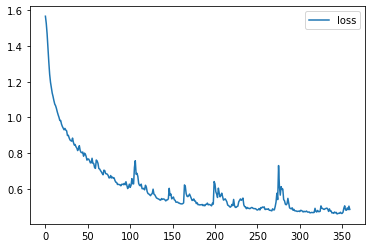

In [24]:
def e8(qx, qy): 
    active_learning(qx, qy, strategy='M', epochs=360)
e8(qx, qy)

In [25]:
assert False

AssertionError: 

In [ ]:
qx1,qy1 = normal_query(budget=128)
qx2,qy2 = most_anomalous_query(budget=256)

qx = np.concatenate((qx1, qx2), axis=0)
qy = np.concatenate((qy1, qy2), axis=0)

print(np.sum(qy1!=0), np.sum(qy2!=0))
print(np.shape(qx))

In [ ]:
#vae.fit(qx, qx, epochs=1)

In [ ]:
def active_learning(x_query, y_query):
    
    y_query = keras.utils.to_categorical(y_query, num_classes=2)
    
    
    #callbacks = [keras.callbacks.ModelCheckpoint(
    #    monitor = 'loss',
    #    filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
    #    save_weights_only = False,
    #    save_best_only = False)]

    history = activeAD.get_supervised().fit(x_query, y_query, shuffle = True, epochs=40, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    y_test = y_test != 0
    y_test = keras.utils.to_categorical(y_test, num_classes=2)
    
    predicted = activeAD.get_supervised().predict(x_test)
    #print(predicted)

    predicted = np.argmax(predicted, axis=-1)
    actual = np.argmax(y_test, axis=-1)

    #print(predicted.shape, predicted)
    #print(actual.shape, actual)
    
    # positiv = anomalous, negative = normal
    n = len(y_test)
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
      
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')

#vae.load_weights(model_str)  
active_learning(qx, qy)

In [ ]:
def active_learning_modelfeedback(normal = 0):
    budget = batch_size 
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]

    history = vae_al.fit(x_query, y_query, shuffle = True, epochs=60, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    
    predicted = vae_al.predict(x_test).reshape(-1) > 0.5
    actual = (y_test != normal)
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(actual)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_modelfeedback()

In [ ]:
def active_learning_decoupled(normal = 0):
    """Enhance the prediction accuracy by retraining the model with the top-k most intersting samples in a
    supervised fashion.
        1) Find the top-k samples and get their labels
        2) Retrain the model with these samples in a supervised fashion -> prevent overfitting
        3) Evaluate accuracy, F1-score, ..."""
    
    budget = batch_size  
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]
    
    z_query = encoder.predict(x_query)

    history = vae_al.fit(z_query, y_query, shuffle = True, epochs=100, batch_size=32)
        #training_data,
        #shuffle=True,      
     #   callbacks = callbacks,
      #  validation_data = (x_valid, y_valid))
    
    x_test, y_test = supervised(dataset = "test")
    z_test = encoder.predict(x_test)
    
    predicted = vae_al.predict(z_test).reshape((-1)) > 0.5
    actual = y_test != normal
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_decoupled()

In [ ]:
visualize_latent_space(None, show_size = True)
anomaly_detection(vae)

In [ ]:
a, b = supervised(dataset="train")

In [ ]:
len(b)

In [ ]:
np.sum(b!=0)